In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# No installation needed on Kaggle for base PyTorch
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:

class Config:
    batch_size = 4
    num_epochs = 5
    lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999
    image_size = 256
    checkpoint_dir = './checkpoints'
    output_dir = './outputs'
    data_dir = '/kaggle/input/6000sarv2/preprocessed'  # Update this!
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = Config()
os.makedirs(cfg.checkpoint_dir, exist_ok=True)
os.makedirs(cfg.output_dir, exist_ok=True)
print(cfg.device)

cuda


In [4]:
# models/generator.py
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=3, n_res_blocks=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]
        # Downsampling
        curr_dim = 64
        for _ in range(2):
            model += [
                nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1),
                nn.InstanceNorm2d(curr_dim * 2),
                nn.ReLU(True)
            ]
            curr_dim *= 2

        # Residuals
        for _ in range(n_res_blocks):
            model += [ResidualBlock(curr_dim)]

        # Upsampling
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(curr_dim, curr_dim // 2, 4, 2, 1),
                nn.InstanceNorm2d(curr_dim // 2),
                nn.ReLU(True)
            ]
            curr_dim = curr_dim // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(curr_dim, out_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [5]:
# models/discriminator.py
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            nn.Conv2d(256, 1, kernel_size=4, padding=1)  # PatchGAN
        )

    def forward(self, x):
        return self.model(x)


In [6]:
# dataset.py
class PreprocessedDataset(Dataset):
    def __init__(self, root):
        self.paths = sorted([os.path.join(root, f) for f in os.listdir(root) if f.endswith('.pt')])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        return torch.load(self.paths[idx])

# Load dataset
dataset = PreprocessedDataset(cfg.data_dir)
loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
print(f"✅ Loaded {len(dataset)} samples.")


✅ Loaded 6000 samples.


✅ Found 6000 samples in dataset
SAR shape: torch.Size([2, 256, 256]), min: -1.00, max: 1.00
EO  shape: torch.Size([3, 256, 256]), min: -1.00, max: 1.00


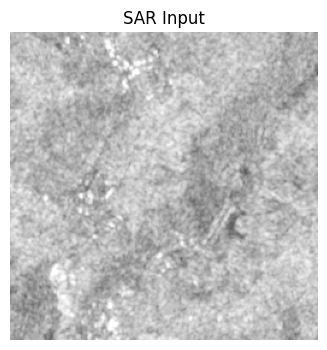

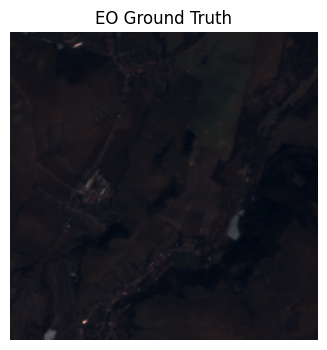

In [7]:
# ------- Load Dataset --------
data_dir = cfg.data_dir  # ✅ change if needed
batch_size = 4

dataset = PreprocessedDataset(data_dir)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"✅ Found {len(dataset)} samples in dataset")
sample = dataset[0]

print(f"SAR shape: {sample['A'].shape}, min: {sample['A'].min():.2f}, max: {sample['A'].max():.2f}")
print(f"EO  shape: {sample['B'].shape}, min: {sample['B'].min():.2f}, max: {sample['B'].max():.2f}")

# ------- Visualize One Sample --------
def imshow(tensor, title, is_sar=False):
    img = tensor.clone().detach().cpu()
    img = img.numpy()
    img = (img + 1) / 2  # [-1,1] -> [0,1]

    if is_sar:
        img = img[0:1].repeat(3, axis=0)  # Convert 2ch to grayscale-RGB
    img = np.transpose(img, (1, 2, 0))  # CHW -> HWC

    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Visualize batch
batch = next(iter(loader))

plt.figure(figsize=(12, 4))
imshow(batch['A'][0], "SAR Input", is_sar=True)
plt.show()

plt.figure(figsize=(12, 4))
imshow(batch['B'][0], "EO Ground Truth")
plt.show()

In [8]:
# utils.py
def save_sample(real_A, fake_B, real_B, path):
    real_A_rgb = real_A[:, :1].repeat(1, 3, 1, 1)  # Convert SAR to fake RGB
    grid = torch.cat([real_A_rgb, fake_B, real_B], dim=3)  # Stack horizontally
    vutils.save_image(grid, path, normalize=True)  # Save as PNG


def init_weights(net):
    for m in net.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [9]:
# train.py
G = Generator().to(cfg.device)
D = Discriminator().to(cfg.device)
init_weights(G)
init_weights(D)

criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

for epoch in range(cfg.num_epochs):
    for i, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}")):
        real_A = batch['A'].to(cfg.device)  # SAR
        real_B = batch['B'].to(cfg.device)  # EO

        # ---------------- Train D ----------------
        optimizer_D.zero_grad()
        fake_B = G(real_A).detach()
        loss_D_real = criterion_GAN(D(real_B), torch.ones_like(D(real_B)))
        loss_D_fake = criterion_GAN(D(fake_B), torch.zeros_like(D(fake_B)))
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # ---------------- Train G ----------------
        optimizer_G.zero_grad()
        fake_B = G(real_A)
        loss_G_GAN = criterion_GAN(D(fake_B), torch.ones_like(D(fake_B)))
        loss_G_L1 = criterion_L1(fake_B, real_B) * 100.0
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        optimizer_G.step()

        # ---------------- Log / Save ----------------
        if i % 100 == 0:
            save_sample(real_A[:1], fake_B[:1], real_B[:1], f"{cfg.output_dir}/sample_e{epoch}_i{i}.png")

    # Save model
    torch.save(G.state_dict(), f"{cfg.checkpoint_dir}/G_epoch{epoch}.pt")
    torch.save(D.state_dict(), f"{cfg.checkpoint_dir}/D_epoch{epoch}.pt")


Epoch 5/5: 100%|██████████| 1500/1500 [05:41<00:00,  4.39it/s]


In [10]:
import matplotlib.pyplot as plt
import torch
import math

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

def show_sample(real_A, fake_B, real_B, idx=0):
    with torch.no_grad():
        # Select the index sample
        sar = real_A[idx:idx+1]
        real = real_B[idx:idx+1]
        fake = fake_B[idx:idx+1]

        # Convert SAR to fake RGB
        sar_rgb = sar[:, :1].repeat(1, 3, 1, 1)

        # Denormalize all
        sar_rgb = denormalize(sar_rgb)[0].cpu()
        real = denormalize(real)[0].cpu()
        fake = denormalize(fake)[0].cpu()

        # Convert to numpy safely
        sar_np = sar_rgb.permute(1, 2, 0).numpy()
        fake_np = fake.permute(1, 2, 0).numpy()
        real_np = real.permute(1, 2, 0).numpy()

        # Plot
        plt.figure(figsize=(12, 4))
        titles = ['Input SAR', 'Generated EO', 'Ground Truth EO']
        for i, img in enumerate([sar_np, fake_np, real_np]):
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()


In [11]:
def compute_psnr(tensor1, tensor2):
    with torch.no_grad():
        tensor1 = denormalize(tensor1).clamp(0, 1)
        tensor2 = denormalize(tensor2).clamp(0, 1)

        mse = torch.mean((tensor1 - tensor2) ** 2)
        if mse == 0:
            return float('inf')
        psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
        return psnr.item()


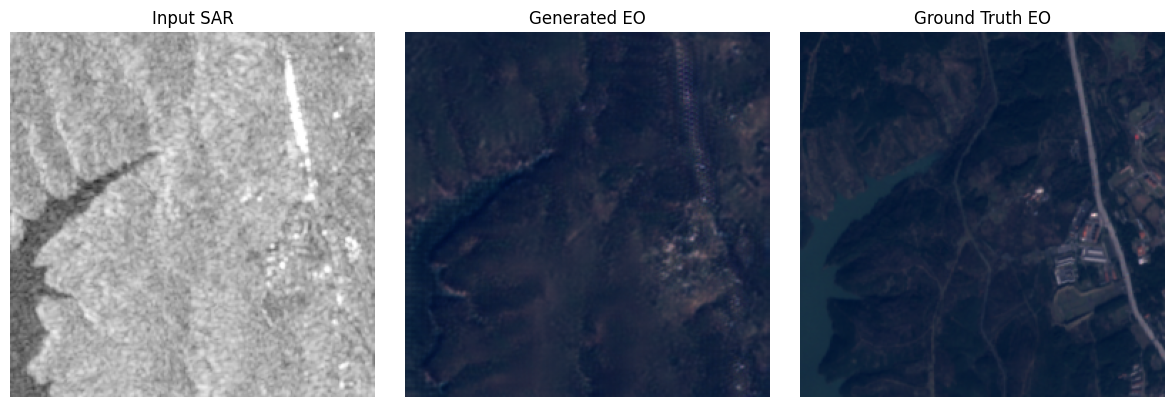

🔍 PSNR: 26.81 dB


In [15]:
with torch.no_grad():
    sample_batch = next(iter(loader))
    real_A = sample_batch['A'].to(cfg.device)
    real_B = sample_batch['B'].to(cfg.device)
    fake_B = G(real_A)

    # Show a visual sample
    show_sample(real_A, fake_B, real_B, idx=0)

    # Print PSNR for that sample
    psnr = compute_psnr(fake_B[0], real_B[0])
    print(f"🔍 PSNR: {psnr:.2f} dB")


In [13]:
import torch
sample = torch.load("/kaggle/input/6000sarv2/preprocessed/sample_0000.pt")
print("SAR shape:", sample['A'].shape, "min:", sample['A'].min().item(), "max:", sample['A'].max().item())
print("EO shape:", sample['B'].shape, "min:", sample['B'].min().item(), "max:", sample['B'].max().item())


SAR shape: torch.Size([2, 256, 256]) min: -1.0 max: 1.0
EO shape: torch.Size([3, 256, 256]) min: -1.0 max: 1.0


In [18]:
import imageio
import glob
from PIL import Image

# Adjust path to your outputs directory
image_folder = "outputs"
output_gif = "training_progress.gif"

# Collect sorted image paths
image_paths = sorted(glob.glob(f"{image_folder}/sample_*.png"))

# Resize (optional): Ensure all images are the same size
images = [Image.open(img).convert("RGB") for img in image_paths]
imageio.mimsave(output_gif, images, duration=0.8)  # 0.8 sec per frame
print("✅ GIF saved as training_progress.gif")


✅ GIF saved as training_progress.gif
